In [1]:
import os
import math
import random
import numpy as np
import tensorflow as tf
import cv2
slim = tf.contrib.slim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('E:\\Mysoftware\\Anaconda\\Lib\\site-packages\\tensorflow\\ssd')

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods

In [5]:
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [6]:
print(sys.path)

['E:\\Mysoftware\\Anaconda\\python36.zip', 'E:\\Mysoftware\\Anaconda\\DLLs', 'E:\\Mysoftware\\Anaconda\\lib', 'E:\\Mysoftware\\Anaconda', '', 'E:\\Mysoftware\\Anaconda\\lib\\site-packages', 'E:\\Mysoftware\\Anaconda\\lib\\site-packages\\win32', 'E:\\Mysoftware\\Anaconda\\lib\\site-packages\\win32\\lib', 'E:\\Mysoftware\\Anaconda\\lib\\site-packages\\Pythonwin', 'E:\\Mysoftware\\Anaconda\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\jing\\.ipython', 'E:\\Mysoftware\\Anaconda\\Lib\\site-packages\\tensorflow\\ssd']


In [7]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [12]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = 'E:\Mysoftware\Anaconda\Lib\site-packages\\tensorflow\ssd\checkpoints/ssd_300_vgg.ckpt'
print(ckpt_filename)
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

E:\Mysoftware\Anaconda\Lib\site-packages\tensorflow\ssd\checkpoints/ssd_300_vgg.ckpt
INFO:tensorflow:Restoring parameters from E:\Mysoftware\Anaconda\Lib\site-packages\tensorflow\ssd\checkpoints/ssd_300_vgg.ckpt


In [13]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [14]:
# Test on some demo image and visualize output.
path = 'C:\\Users\\jing\\Pictures\\abzu'
image_names = sorted(os.listdir(path))
print(image_names)

['fish.jpg', 'ghj.jpg', 'tim.jpg', 'timg.jpg']


In [15]:

img = mpimg.imread('C:\\Users\\jing\\Pictures\\abzu\\tim.jpg')


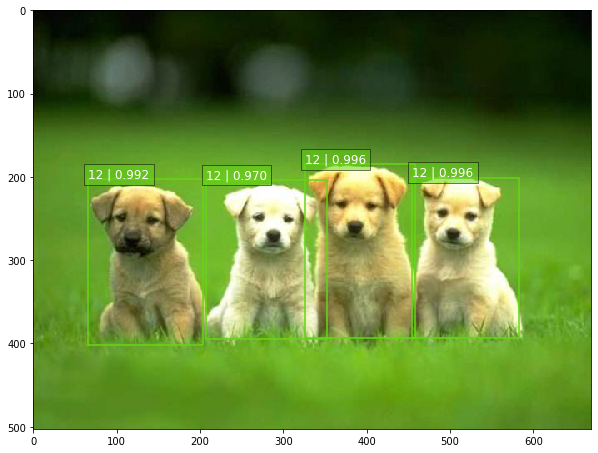

In [16]:
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [17]:
img = mpimg.imread('C:\\Users\\jing\\Pictures\\abzu\\fish.jpg')

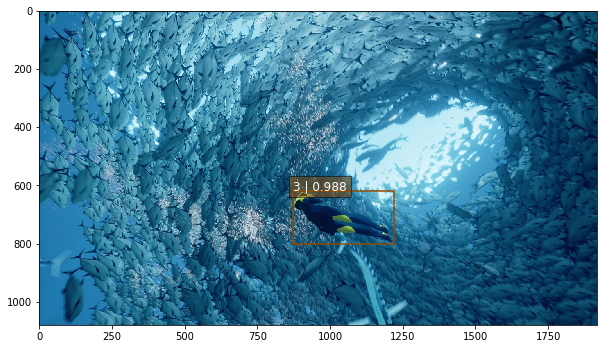

In [18]:
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

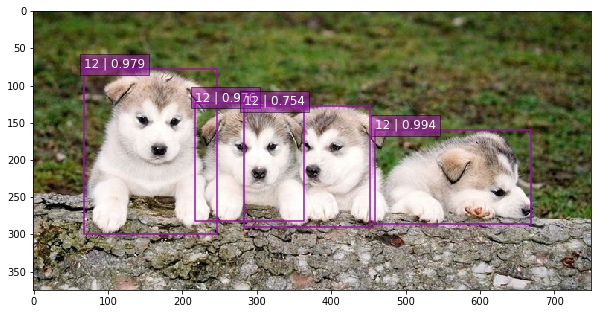

In [21]:
img = mpimg.imread('C:\\Users\\jing\\Pictures\\abzu\\ghj.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

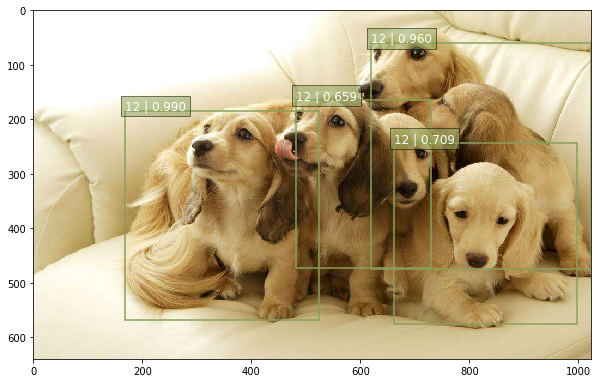

In [22]:
img = mpimg.imread('C:\\Users\\jing\\Pictures\\abzu\\timg.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

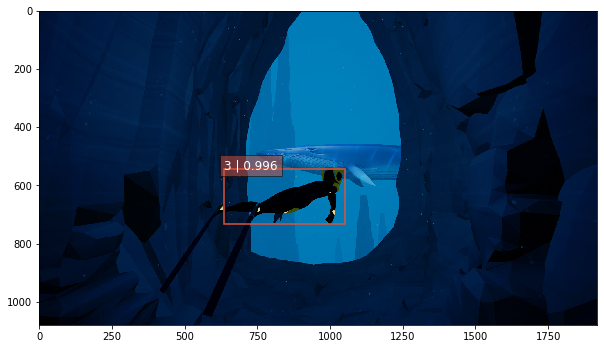

In [24]:
img = mpimg.imread('C:\\Users\\jing\\Pictures\\abzu\\j.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

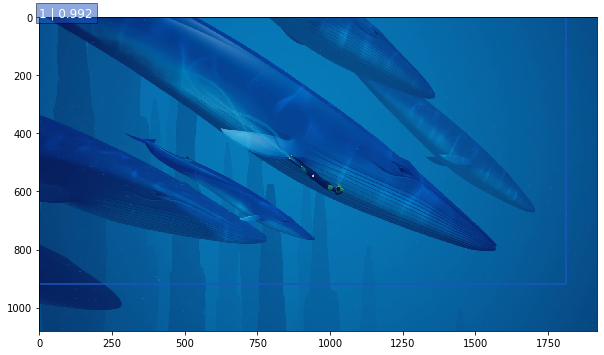

In [26]:
img = mpimg.imread('C:\\Users\\jing\\Pictures\\abzu\\z.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)